In [1]:
import numpy as np
np.random.seed(10)

# Sigmoid Activation

We'll also stop using pytorch here because matmul exists in numpy anyways; it's all numpy implementation yay

DATA GENERATION

In [2]:
# 3 inputs, 4 hiddens, 2 outputs
dim_in = 3
dim_hidden = 4
dim_out = 2
# x,y,z point classification task

line0init = np.array([0, 1, 0])
line0vec = np.array([1, 3, -5])

line1init = np.array([-1, 0, 0])
line1vec = np.array([3, -1, 2])

# closest distance between line 0 and line 1: https://www.geeksforgeeks.org/shortest-distance-between-two-lines-in-3d-space-class-12-maths/
cross01 = np.cross(line0vec, line1vec)
mulc = cross01.copy() * (line1init - line0init)
dist = np.sqrt(mulc.dot(mulc)) / np.sqrt(cross01.dot(cross01))
print("DIST:", dist)

def get_line(num:int):
  if num == 0:
    return line0init + (np.random.random()-0.5)*5*line0vec + np.random.normal(scale=0.2, size=(3, )).clip(-0.45, 0.45)*dist
  else:
    return line1init + (np.random.random()-0.5)*5*line1vec + np.random.normal(scale=0.2, size=(3, )).clip(-0.45, 0.45)*dist


def get_batch(batch_size=1000):
  labels = np.random.randint(0, 2, size=(batch_size,1))
  xss = []
  for label in labels:
    xss.append(get_line(label).reshape((-1,1)))
  xs = np.stack(xss)
  ys = np.stack([labels==0, labels==1], axis=1)
  #print(labels[:5])
  #print(ys[:5])
  return xs, ys.astype(np.int32)

'''l = get_line(0)
print(l.shape)
print(l)
print(line0init.shape)
print(((np.random.random()-0.5)*5*line0vec).shape)
print((np.random.normal(scale=0.2, size=(3, 1)).clip(-0.5, 0.5)*dist ).shape)
print()
print((line0init + ((np.random.random()-0.5)*5*line0vec)).shape)
print((((np.random.random()-0.5)*5*line0vec) + (np.random.normal(scale=0.2, size=(3, )).clip(-0.5, 0.5)*dist )).shape)


print()
print()
print() '''


xs, ys = get_batch(1000)
print(xs.shape)
print(ys.shape)


DIST: 0.8623164985025764
(1000, 3, 1)
(1000, 2, 1)


BACKPROPAGATION AND FUNCTIONS

In [3]:
# binary crossentropy
def CEloss(p_s0, p_s1, y_0, y_1):
  return (-1/np.log(2)) * (y_0*np.log(p_s0) + y_1*np.log(p_s1))

def accuracy(p_s, y):
  pred = p_s.squeeze().argmax(axis=1)
  ys = y.squeeze().argmax(axis=1)
  #print('pred',pred.shape)
  #print("y", ys.shape)
  return ((pred+ys+1)%2).sum() / y.shape[0] 

# sigmoid activation
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

# softmax
def softmax(p):
  t = np.exp(p[0]) + np.exp(p[1])
  return np.stack([np.exp(p[0])/t, np.exp(p[1])/t])
def softmax_batched(p):
  t = np.exp(p[:,0]) + np.exp(p[:,1])
  #print("T:",t)
  return np.stack([np.exp(p[:,0])/t, np.exp(p[:,1])/t], axis=1)
#print(softmax(np.array([[1],[2]])))
#print(softmax_batched(np.array([ [[1],[2]] , [[1],[2]] , [[1],[2]] ])))

# layer
def layer(test_x, test_w, test_b):
  return test_w@test_x + test_b


# derivatives

# y is y[:,0] and y[:,1]
# p_0 is p_0[:,0] and p_0[:,1]
# x h_0 h_s p_0 y
# i skipped p_s because it cld save computation time

def dCE_dp_0_0(**kwargs): # unbatched
  return (-1/np.log(2)) * (kwargs['y'][0,0]*np.exp(kwargs['p_0'][1,0]) - kwargs['y'][1,0]*np.exp(kwargs['p_0'][0,0])) / (np.exp(kwargs['p_0'][0,0]) + np.exp(kwargs['p_0'][1,0]))
def batched_dCE_dp_0_0(**kwargs):
  return ( (-1/np.log(2)) * (kwargs['y'][:,0,0]*np.exp(kwargs['p_0'][:,1,0]) - kwargs['y'][:,1,0]*np.exp(kwargs['p_0'][:,0,0])) / (np.exp(kwargs['p_0'][:,0,0]) + np.exp(kwargs['p_0'][:,1,0])) ).reshape(-1,1)

def dCE_dp_0_1(**kwargs):
  return -dCE_dp_0_0(**kwargs)
def batched_dCE_dp_0_1(**kwargs):
  return -batched_dCE_dp_0_0(**kwargs)

def dCE_dp_0(**kwargs):
  dcedp00 = dCE_dp_0_0(**kwargs)
  return np.array([[dcedp00], [-dcedp00]])
def batched_dCE_dp_0(**kwargs):
  dcedp00 = batched_dCE_dp_0_0(**kwargs)
  return np.stack([dcedp00, -dcedp00], axis=1)

def dCE_db_2(**kwargs):
  return dCE_dp_0(**kwargs)
def batched_dCE_db_2(**kwargs):
  return batched_dCE_dp_0(**kwargs)

def dCE_dw_2(**kwargs):
  return dCE_dp_0(**kwargs) @ kwargs['h_s'].swapaxes(-1, -2)
def batched_dCE_dw_2(**kwargs):
  return batched_dCE_dp_0(**kwargs) @ kwargs['h_s'].swapaxes(-1, -2)

def dCE_dh_s(**kwargs):
  return kwargs['w_2'].swapaxes(-1, -2) @ dCE_dp_0(**kwargs)
def batched_dCE_dh_s(**kwargs):
  return kwargs['w_2'].swapaxes(-1, -2) @ batched_dCE_dp_0(**kwargs)

def dCE_dh_0(**kwargs):
  return sigmoid(kwargs['h_0'])*(1-sigmoid(kwargs['h_0']))*dCE_dh_s(**kwargs)
def batched_dCE_dh_0(**kwargs):
  return sigmoid(kwargs['h_0'])*(1-sigmoid(kwargs['h_0']))*batched_dCE_dh_s(**kwargs)

def dCE_db_1(**kwargs):
  return dCE_dh_0(**kwargs)
def batched_dCE_db_1(**kwargs):
  return batched_dCE_dh_0(**kwargs)

def dCE_dw_1(**kwargs):
  return dCE_dh_0(**kwargs) @ kwargs['x'].swapaxes(-1, -2)
def batched_dCE_dw_1(**kwargs):
  return batched_dCE_dh_0(**kwargs) @ kwargs['x'].swapaxes(-1, -2)




In [4]:
# initialize params

w1, b1 = np.random.random((dim_hidden, dim_in)), np.random.random((dim_hidden, 1))
w2, b2 = np.random.random((dim_out, dim_hidden)), np.random.random((dim_out, 1))

def get_lr(epochNum:int=0):
  return (5e-4)*(np.exp(-0.00004*epochNum))

In [5]:
eval_batch_size = 1000
ex, ey = get_batch(eval_batch_size)

def evaluate(epochNum:int = None):
  # get output
  h_0 = layer(ex, w1, b1)
  h_s = sigmoid(h_0)
  p_0 = layer(h_s, w2, b2)
  p_s = softmax_batched(p_0)

  # get loss
  loss = CEloss(p_s[:,0,0], p_s[:,1,0], ey[:,0,0], ey[:,1,0]).mean()

  # display
  if epochNum is None:
    print('EVAL LOSS:', loss)
  else:
    print('EPOCH', epochNum, 'AVG EVAL LOSS FOR BATCH SIZE '+str(eval_batch_size)+':', loss)

  print("ACCURACY:", accuracy(p_s, ey))

  return loss


train_epoch_losses = []
eval_epoch_losses = []

epoch = 0
batches_per_epoch = 100
batch_size = 100
avgepochloss = 10
while avgepochloss > 0.02:

  epochtotalloss = 0

  for batchnum in range(batches_per_epoch):
    # get data
    x, y = get_batch(batch_size)

    # run through model
    h_0 = layer(x, w1, b1)
    h_s = sigmoid(h_0)
    p_0 = layer(h_s, w2, b2)
    p_s = softmax_batched(p_0)

    #print('x', x)
    #print('h_0', h_0)
    #print('h_s', h_s)
    #print('p_0', p_0)
    #print('p_s', p_s)
    #print('y', y)


    # get loss
    loss = CEloss(p_s[:,0,0], p_s[:,1,0], y[:,0,0], y[:,1,0]).mean()
    #print("RAW LOSS:", CEloss(p_s[:,0,0], p_s[:,1,0], y[:,0,0], y[:,1,0]))
    #print("LOSS:", loss)

    #1/0

    # update params
    lr = get_lr(epoch)
    dCE_kwargs = {
        'x': x,
        'h_0': h_0,
        'h_s': h_s,
        'p_0': p_0,
        'y': y,
        'w_1': w1,
        'w_2': w2,
    }
    w2 -= lr*batched_dCE_dw_2(**dCE_kwargs).sum(0)*loss
    b2 -= lr*batched_dCE_db_2(**dCE_kwargs).sum(0)*loss
    w1 -= lr*batched_dCE_dw_1(**dCE_kwargs).sum(0)*loss
    b1 -= lr*batched_dCE_db_1(**dCE_kwargs).sum(0)*loss

    epochtotalloss += loss

  avgepochloss = epochtotalloss/batches_per_epoch

  if epoch%5 == 0:
    eval_loss = evaluate(epoch)
    print(epoch, "     AVG TRAIN LOSS FOR BATCH SIZE "+str(batch_size)+":", avgepochloss)
    if len(eval_epoch_losses) > 0: 
      if eval_loss > eval_epoch_losses[-1]: # loss is increasing oh no 
        eval_epoch_losses.append(eval_loss)
        break # terminate 
    eval_epoch_losses.append(eval_loss) # includes epoch 0
  elif epoch < 5:
    print("EPOCH", epoch, "AVG TRAIN LOSS FOR BATCH SIZE "+str(batch_size)+":", avgepochloss)

  epoch += 1
  train_epoch_losses.append(avgepochloss)

print("converged !! ")


EPOCH 0 AVG EVAL LOSS FOR BATCH SIZE 1000: 0.9482988725270642
ACCURACY: 0.642
0      AVG TRAIN LOSS FOR BATCH SIZE 100: 0.9861363270146586
EPOCH 1 AVG TRAIN LOSS FOR BATCH SIZE 100: 0.9235551812510121
EPOCH 2 AVG TRAIN LOSS FOR BATCH SIZE 100: 0.8596389743407566
EPOCH 3 AVG TRAIN LOSS FOR BATCH SIZE 100: 0.7938692940662784
EPOCH 4 AVG TRAIN LOSS FOR BATCH SIZE 100: 0.7286214607830125
EPOCH 5 AVG EVAL LOSS FOR BATCH SIZE 1000: 0.637947669837025
ACCURACY: 0.806
5      AVG TRAIN LOSS FOR BATCH SIZE 100: 0.6646480803994271
EPOCH 10 AVG EVAL LOSS FOR BATCH SIZE 1000: 0.40938956061482573
ACCURACY: 0.999
10      AVG TRAIN LOSS FOR BATCH SIZE 100: 0.41701735874680557
EPOCH 15 AVG EVAL LOSS FOR BATCH SIZE 1000: 0.3068975757097986
ACCURACY: 0.998
15      AVG TRAIN LOSS FOR BATCH SIZE 100: 0.3071720676981112
EPOCH 20 AVG EVAL LOSS FOR BATCH SIZE 1000: 0.2528420568497782
ACCURACY: 0.998
20      AVG TRAIN LOSS FOR BATCH SIZE 100: 0.2561379312559856
EPOCH 25 AVG EVAL LOSS FOR BATCH SIZE 1000: 0.2185

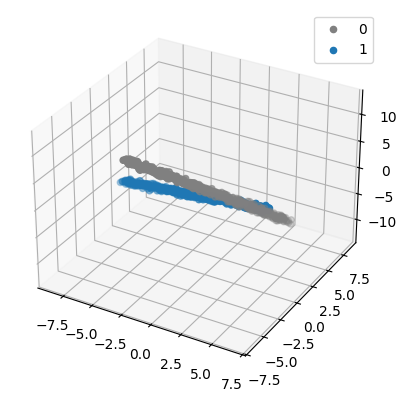

In [6]:
# visualize the test data (i didnt add model visualization as it was a bit tricky oop)

import matplotlib.pyplot as plt 

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

c = ey.squeeze()[:,1]
t_0 = ex[c==0].squeeze()
t_1 = ex[c==1].squeeze() 

ax.scatter(t_0[:,0], t_0[:,1], t_0[:,2], c='gray', label='0')
ax.scatter(t_1[:,0], t_1[:,1], t_1[:,2], c='tab:blue', label='1')

plt.legend() 
plt.show() 
